# IDS_H2 - Analyzing and Predicting Top Songs on Spotify

**Authors**: Sandra Schihalejev, Samuel Amankwaa, Merilin Radvilavicius

**Dataset from Kaggle**: https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated/versions/49

The Jupyter Notebook includes steps, which were needed to satisfy our needs to find out, what makes a song popular on Spotify and how to predict it in the best possible way.

The notebook consists following steps:

**0. Feature Engineering**  

**1. First Look At The Data**  

    1.1. Top Artists (including collabrations)  
    
        1.1.1 Top Bad Bunny Songs  
        
    1.2 Top Solo Artists and Collabrations  
    
        1.2.1 Top Taylor Swift Songs  
        
    1.3 Top Songs  
    
    1.4 Top Albums  
    
    1.5 Represented Countries  
    
    1.6 Computational Statistics for Numerical Attributes  
        
        1.6.1 Continuous Attributes  
        
        1.6.2 Discrete Attributes  
**2. Correlation Matrix**  

**3. Multi-variate Linear Regression Models**  

    3.1 Stright Forward With All Numerical Features  
    
    3.2 Finding Statistically Significant (p = 0.05) Features  
    
**4. Random Forest**  

**5. Conclusions**

In [1]:
# Importing all necessary libraries and modules for this project

# For data manipulation
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, time

# For vizualisations
import matplotlib.pyplot as plt
import seaborn as sns

# For modelling
import statsmodels.api as sm
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("universal_top_spotify_songs.csv")

In [3]:
df.head()

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,3rUGC1vUpkDG9CZFHMur1t,greedy,Tate McRae,1,0,0,NaN,2023-11-30,100,True,...,6,-3.180,0,0.0319,0.2560,0.000000,0.1140,0.844,111.018,1
1,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,Mariah Carey,2,1,15,NaN,2023-11-30,94,False,...,7,-7.463,1,0.0384,0.1640,0.000000,0.0708,0.350,150.273,4
2,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,3,1,0,NaN,2023-11-30,94,True,...,2,-4.911,1,0.0568,0.0026,0.000002,0.0937,0.606,104.983,4
3,3vkCueOmm7xQDoJ17W1Pm3,My Love Mine All Mine,Mitski,4,-2,-2,NaN,2023-11-30,98,False,...,9,-14.958,1,0.0321,0.8680,0.135000,0.1580,0.121,113.950,4
4,06qMRF18gwbOYYbnP2du6i,Last Christmas - Single Version,Wham!,5,0,16,NaN,2023-11-30,82,False,...,2,-8.228,1,0.0278,0.2120,0.000004,0.1560,0.935,107.732,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160133 entries, 0 to 160132
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   spotify_id          160133 non-null  object 
 1   name                160112 non-null  object 
 2   artists             160112 non-null  object 
 3   daily_rank          160133 non-null  int64  
 4   daily_movement      160133 non-null  int64  
 5   weekly_movement     160133 non-null  int64  
 6   country             157977 non-null  object 
 7   snapshot_date       160133 non-null  object 
 8   popularity          160133 non-null  int64  
 9   is_explicit         160133 non-null  bool   
 10  duration_ms         160133 non-null  int64  
 11  album_name          160101 non-null  object 
 12  album_release_date  160101 non-null  object 
 13  danceability        160133 non-null  float64
 14  energy              160133 non-null  float64
 15  key                 160133 non-nul

In [5]:
df.memory_usage(deep=True).sum() # 102626617 bytes = 102626,617 kB = 102,627 MB

102626617

Some basic information abou the dataset. As we see, there are total of 160 133 rows and 25 columns and the memory usage is 102,627 MB.

# 0. Feature Engineering
For the sake of convenience and understanding, we do some data type formattings and other convertings beforehand.

In [6]:
# Formatting dates as type 'datetime' instead of 'object'
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')
df['album_release_date'] = pd.to_datetime(df['album_release_date'], format='%Y-%m-%d')

In [7]:
# Converting feature is_explicit as type 'int' (True=1 and False=0) as it is easier to do modelling
df['is_explicit'] = df['is_explicit'].astype(int)

In [8]:
# Replacing 'NaN' with 'Global' as it is easier to understand it by just looking
df['country'] = df['country'].fillna(value='Global')

# 1. First Look  At The Data
Here we present some computational statistics to find possible errors and inconsistencies. Also, we present the visualizations.

During the processe, we found inconsistencies related to the attribute 'duration_ms', where some songs (n = 3) lasted for 0 ms (= 0 s) and which is not logical. To already have clean data for visualizations, we performed all the data cleaning beforehand.

In [9]:
df_zero_duration = df[df.duration_ms == 0]
display(df_zero_duration)
df_zero_duration.spotify_id.value_counts()

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
72795,7lyv2sysHCzFjypILxAynT,NaN,NaN,36,14,14,VE,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
73127,7lyv2sysHCzFjypILxAynT,NaN,NaN,18,32,32,SV,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
73664,7lyv2sysHCzFjypILxAynT,NaN,NaN,5,45,45,PE,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
73741,7lyv2sysHCzFjypILxAynT,NaN,NaN,32,18,18,PA,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
73955,7lyv2sysHCzFjypILxAynT,NaN,NaN,46,4,4,NI,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
74823,7lyv2sysHCzFjypILxAynT,NaN,NaN,25,25,25,HN,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
74927,7lyv2sysHCzFjypILxAynT,NaN,NaN,29,21,21,GT,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
75160,7lyv2sysHCzFjypILxAynT,NaN,NaN,12,38,38,ES,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
75315,7lyv2sysHCzFjypILxAynT,NaN,NaN,17,33,33,EC,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4
75569,7lyv2sysHCzFjypILxAynT,NaN,NaN,21,29,29,CR,2023-11-10,0,1,...,0,-4.643,1,0.0517,0.0232,0.000,0.0699,0.533,90.019,4


7lyv2sysHCzFjypILxAynT    13
0kvD9ksvXyRHANPypIpkIh     7
6yxtsR3nc3aUL1wcbLn8A3     1
Name: spotify_id, dtype: int64

In [10]:
df = df[df.duration_ms != 0]

# For convenience, let's convert milliseconds (ms) to seconds (s)
df.duration_ms = df["duration_ms"]/ 1000
df = df.rename(columns={'duration_ms': 'duration_s'})
df

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,3rUGC1vUpkDG9CZFHMur1t,greedy,Tate McRae,1,0,0,Global,2023-11-30,100,1,...,6,-3.180,0,0.0319,0.2560,0.000000,0.1140,0.844,111.018,1
1,0bYg9bo50gSsH3LtXe2SQn,All I Want for Christmas Is You,Mariah Carey,2,1,15,Global,2023-11-30,94,0,...,7,-7.463,1,0.0384,0.1640,0.000000,0.0708,0.350,150.273,4
2,4xhsWYTOGcal8zt0J161CU,Lovin On Me,Jack Harlow,3,1,0,Global,2023-11-30,94,1,...,2,-4.911,1,0.0568,0.0026,0.000002,0.0937,0.606,104.983,4
3,3vkCueOmm7xQDoJ17W1Pm3,My Love Mine All Mine,Mitski,4,-2,-2,Global,2023-11-30,98,0,...,9,-14.958,1,0.0321,0.8680,0.135000,0.1580,0.121,113.950,4
4,06qMRF18gwbOYYbnP2du6i,Last Christmas - Single Version,Wham!,5,0,16,Global,2023-11-30,82,0,...,2,-8.228,1,0.0278,0.2120,0.000004,0.1560,0.935,107.732,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160128,0AYt6NMyyLd0rLuvr0UkMH,Slime You Out (feat. SZA),"Drake, SZA",46,4,0,AE,2023-10-18,84,1,...,5,-9.243,0,0.0502,0.5080,0.000000,0.2590,0.105,88.880,3
160129,2Gk6fi0dqt91NKvlzGsmm7,SAY MY GRACE (feat. Travis Scott),"Offset, Travis Scott",47,3,0,AE,2023-10-18,80,1,...,10,-5.060,1,0.0452,0.0585,0.000000,0.1320,0.476,121.879,4
160130,26b3oVLrRUaaybJulow9kz,People,Libianca,48,2,0,AE,2023-10-18,88,0,...,10,-7.621,0,0.0678,0.5510,0.000013,0.1020,0.693,124.357,5
160131,5ydjxBSUIDn26MFzU3asP4,Rainy Days,V,49,1,0,AE,2023-10-18,88,0,...,9,-8.016,0,0.0875,0.7390,0.000000,0.1480,0.282,74.828,4


In total of 21 rows (3 songs) were removed. Now there are total of **160 112** rows in the dataset.

To check for any NaN values:

In [11]:
# Check for NaN values in each column
nan_columns = df.columns[df.isna().any()].tolist()

if nan_columns:
    print(f"The following columns have NaN values: {nan_columns}")
else:
    print("There are no NaN values in any column.")

The following columns have NaN values: ['album_name', 'album_release_date']


As we see, there are missing values in columns album_name and album_release_date. Let's find out those rows:

In [12]:
columns_to_check = ['album_name', 'album_release_date']

# Create a subset with rows containing missing values in specific columns
df_nan = df[df[columns_to_check].isna().any(axis=1)]
df_nan

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
287,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,38,0,12,US,2023-11-30,81,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
3937,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,38,-15,12,US,2023-11-29,81,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
7572,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,23,3,27,US,2023-11-28,80,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
10475,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,33,6,17,CA,2023-11-28,80,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
11218,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,26,2,24,US,2023-11-27,79,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
12136,3yrSvpt2l1xhsV9Em88Pul,Brown Eyed Girl,Van Morrison,44,6,2,NZ,2023-11-27,83,0,...,7,-10.964,1,0.0376,0.185,0.0,0.4060,0.908,150.566,4
14131,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,39,11,11,CA,2023-11-27,79,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
14870,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,28,14,22,US,2023-11-26,78,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
18534,4HEOgBHRCExyYVeTyrXsnL,Jingle Bells - Remastered 1999,Frank Sinatra,42,8,8,US,2023-11-25,77,0,...,8,-13.119,1,0.0498,0.727,0.0,0.0977,0.951,174.609,4
37724,3yrSvpt2l1xhsV9Em88Pul,Brown Eyed Girl,Van Morrison,46,4,3,NZ,2023-11-20,83,0,...,7,-10.964,1,0.0376,0.185,0.0,0.4060,0.908,150.566,4


In [13]:
df_beg = df[df.name == "Brown Eyed Girl"]
print("Brown Eyed Girl")
display(df_beg.album_name)

df_jbr1999 = df[df.name == "Jingle Bells - Remastered 1999"]
print("Jingle Bells - Remastered 1999")
display(df_jbr1999.album_name)

Brown Eyed Girl


12136    NaN
37724    NaN
62932    NaN
Name: album_name, dtype: object

Jingle Bells - Remastered 1999


287      NaN
3937     NaN
7572     NaN
10475    NaN
11218    NaN
14131    NaN
14870    NaN
18534    NaN
Name: album_name, dtype: object

Seems like those songs were not part of any album, so there is no need to worry about those missing values as they are not mistakes.

## 1.1 Top Artists (including collabrations)
First of all let's have an overview how many unique artists we have in the dataset, whether they appear as solo or featuring artists, e.g. 'Jung Kook' and 'Jung Kook, Latto' counts Junk Kook as artist twice.

In [14]:
top_artists_df = df['artists'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='artists')

artist_counts = top_artists_df['artists'].value_counts()
artist_counts

Bad Bunny       9410
Taylor Swift    5314
Feid            4145
Jung Kook       4047
Peso Pluma      2824
                ... 
Justin99           1
Pcee               1
Mr JazziQ          1
boygenius          1
Khuthuza           1
Name: artists, Length: 3242, dtype: int64

As we see, there are a total of 3242 unique artists in the dataset.

Let's visualize top 10 artists appearing in the dataset:

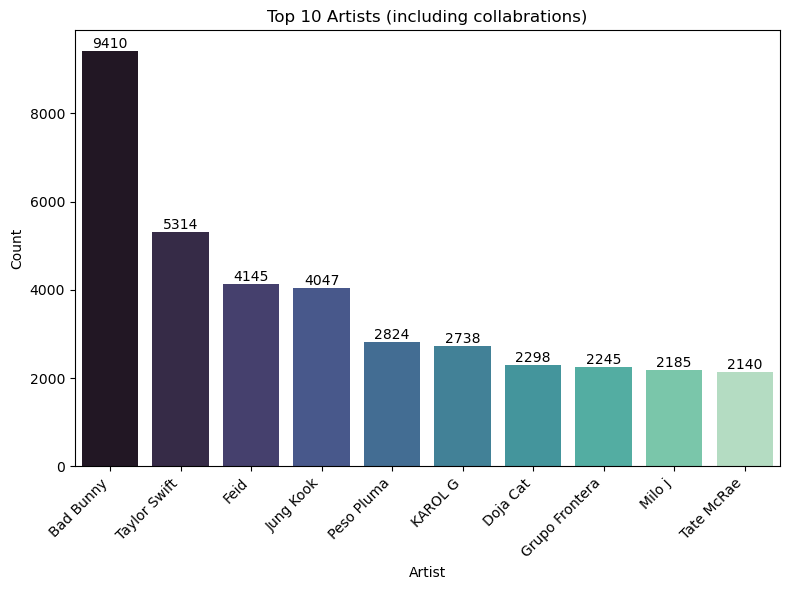

In [15]:
# Perform value counts on the new DataFrame
top_artist_counts = top_artists_df['artists'].value_counts().head(10)

# Create a DataFrame for the top 10 artists
top_artist_counts_df = pd.DataFrame({'Artist': top_artist_counts.index, 'Count': top_artist_counts.values})

# Plotting with seaborn
plt.figure(figsize=(8, 6))
plot = sns.barplot(x='Artist', y='Count', data=top_artist_counts_df, palette='mako')

# Display count values on top of the bars
for index, value in enumerate(top_artist_counts_df['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Artist')
plt.ylabel('Count')
plt.title('Top 10 Artists (including collabrations)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

#plt.savefig('top_artists.png', dpi=300)  # Adjust dpi for better resolution

# Show the plot
plt.show()


### 1.1.1 Top Bad Bunny Songs
As Bad Bunny appears the most in the dataset, we visualize his most appearing songs.

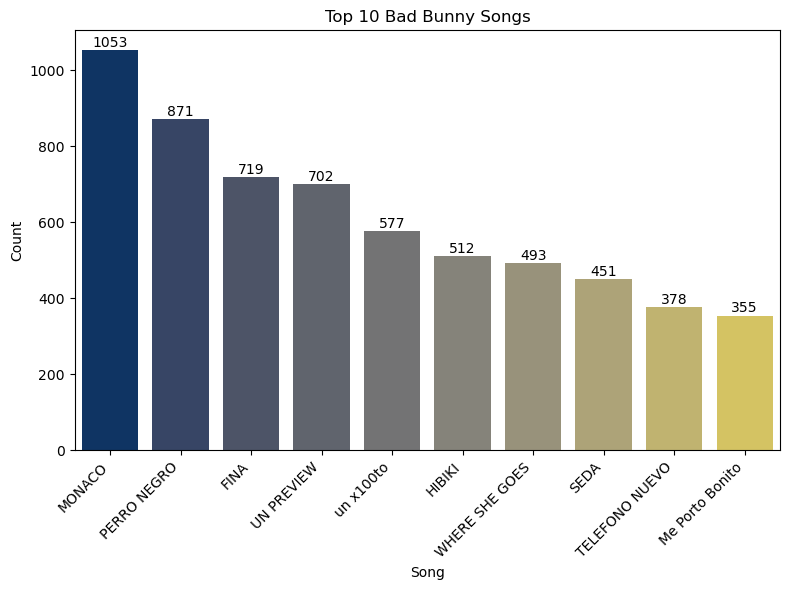

In [16]:
# Filter the DataFrame for Bad Bunny songs
bad_bunny_df = df[df["artists"].str.contains('Bad Bunny', case=False, na=False)]

# Get the counts for each Bad Bunny song
bad_bunny_counts = bad_bunny_df['name'].value_counts().head(10)

# Create a DataFrame for the top 10 Bad Bunny songs
top_bad_bunny_df = pd.DataFrame({'Song Name': bad_bunny_counts.index, 'Count': bad_bunny_counts.values})

# Plotting with seaborn
plt.figure(figsize=(8, 6))
plot = sns.barplot(x='Song Name', y='Count', data=top_bad_bunny_df, palette='cividis')

# Display count values on the bars
for index, value in enumerate(top_bad_bunny_df['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', color='black')

plt.xlabel('Song')
plt.ylabel('Count')
plt.title('Top 10 Bad Bunny Songs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()

#plt.savefig('top_bad_bunny_songs.png', dpi=300)  # Adjust dpi for better resolution

# Show the plot
plt.show()


## 1.2 Top Solo Artists and Collabrations
Let's have an overview how many unique artists and collabrations we have in the dataset, e.g. 'Jung Kook' and 'Jung Kook, Latto' are treated as two individual unions.

In [17]:
solo_artists = df['artists'].value_counts()
solo_artists

Taylor Swift            5304
Bad Bunny               4093
Doja Cat                2298
Tate McRae              2140
iñigo quintero          1756
                        ... 
Pasi ja Anssi, Faija       1
Nasboi, Wande Coal         1
Nik & Jay                  1
Jamaika, M24               1
Zodiaks                    1
Name: artists, Length: 2729, dtype: int64

As we see, there are a total of 2729 unique artists and collabrations in the dataset, which means some artists appear only in the collabrations.

Let's visualize top 10 solo artists and collabrations appearing in the dataset.

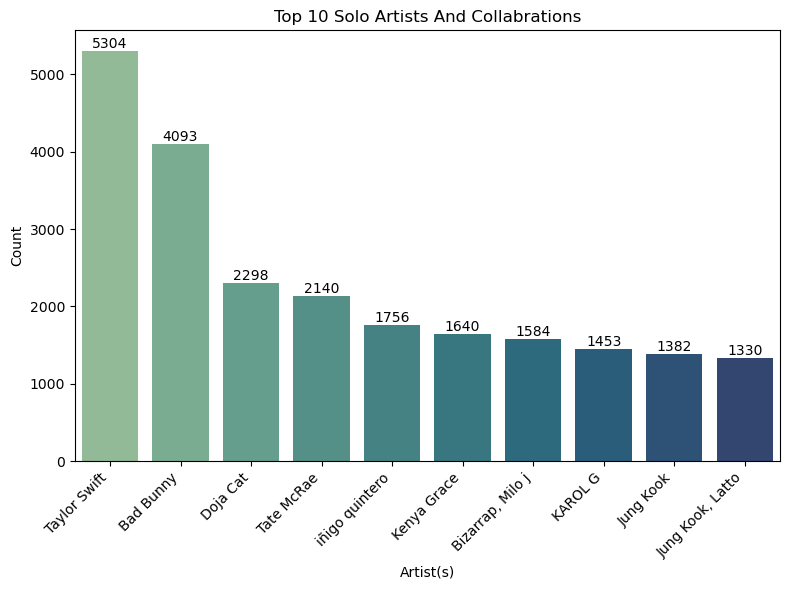

In [18]:
# Get the top 10 artists
top_solo_artists = df['artists'].value_counts().head(10)

# Create a DataFrame for the top 10 artists
top_solo_artists_df = pd.DataFrame({'Artist': top_solo_artists.index, 'Count': top_solo_artists.values})

# Plotting with seaborn
plt.figure(figsize=(8, 6))
plot = sns.barplot(x='Artist', y='Count', data=top_solo_artists_df, palette='crest')

# Display count values on top of the bars
for index, value in enumerate(top_solo_artists_df['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', color='black')

plt.xlabel('Artist(s)')
plt.ylabel('Count')
plt.title('Top 10 Solo Artists And Collabrations')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

#plt.savefig('top_solo_artists_collabrations.png', dpi=300)  # Adjust dpi for better resolution

# Show the plot
plt.show()

### 1.2.1 Top Taylor Swift Songs
Visualizing Taylor Swift as solo artist top songs. 

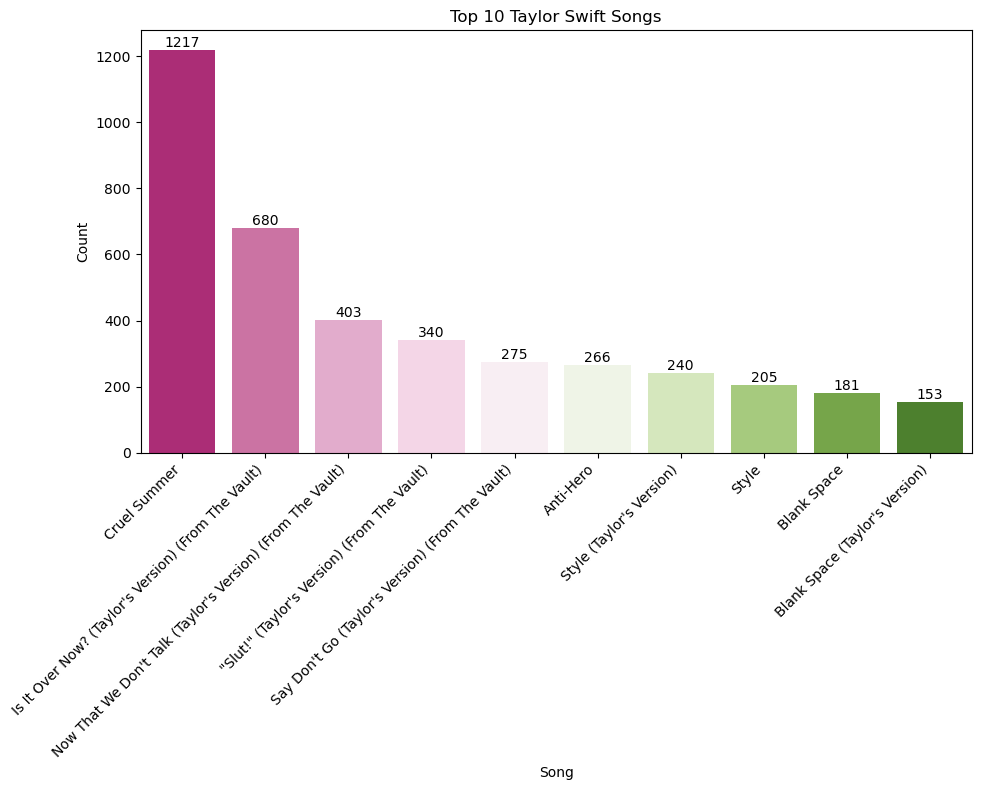

In [19]:
# Filter the DataFrame for Taylor Swift songs
taylor_swift_df = df[df["artists"].str.contains('Taylor Swift', case=False, na=False)]

# Get the counts for each Taylor Swift song
taylor_swift_counts = taylor_swift_df['name'].value_counts().head(10)

# Create a DataFrame for the top 10 Taylor Swift songs
top_taylor_swift_df = pd.DataFrame({'Song Name': taylor_swift_counts.index, 'Count': taylor_swift_counts.values})

# Plotting with seaborn
plt.figure(figsize=(10, 8))
plot = sns.barplot(x='Song Name', y='Count', data=top_taylor_swift_df, palette='PiYG')

# Display count values on the bars
for index, value in enumerate(top_taylor_swift_df['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', color='black')

plt.xlabel('Song')
plt.ylabel('Count')
plt.title('Top 10 Taylor Swift Songs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()

#plt.savefig('top10_taylor_swift_songs.png', dpi=300)  # Adjust dpi for better resolution

# Show the plot
plt.show()


## 1.3 Top Songs
Let's have an overview how many unique songs we have in the dataset.

In [20]:
song_names = df['spotify_id'].value_counts()
song_names

3rUGC1vUpkDG9CZFHMur1t    1919
2HafqoJbgXdtjwCOvNEF14    1756
56y1jOTK0XSvJzVv9vHQBK    1700
5mjYQaktjmjcMKcUIcqz4s    1640
1BxfuPKGuaTgP7aM0Bbdwr    1217
                          ... 
3tlG0NcGrPLnM4V6SlqtWW       1
79gUiYKiISCPKBAy5YDdtD       1
2zu2gViGH8vMhNMuSx6n1h       1
5f04ru78OZVD8cQnvJ1NDD       1
1SwY9YgXVgRbZM6uzxS4vU       1
Name: spotify_id, Length: 3882, dtype: int64

As we see, there are total of 3882 unique songs, which means some artists have multiple songs in the rankings.

Let's visualize the songs (with its performer(s)) appearing in the dataset.

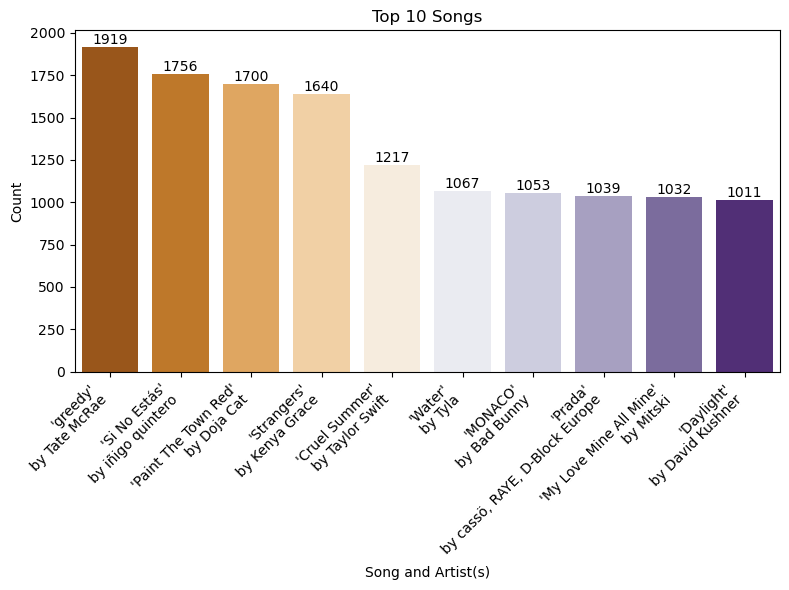

In [21]:
# Create a DataFrame for the top 10 spotify_ids
id_counts = df['spotify_id'].value_counts()

# Create a DataFrame for the top 10 spotify_ids
top_ids_df = pd.DataFrame({'spotify_id': id_counts.index, 'Count': id_counts.values}).head(10)

# Merge the top_ids_df with the original DataFrame to get corresponding song names and artists
merged_df = pd.merge(top_ids_df, df[['spotify_id', 'name', 'artists']], on='spotify_id', how='left')

# Concatenate 'song_name' and 'artist' for x-axis labels
merged_df['song_artist'] = "'" +merged_df['name'] + "'\n by " + merged_df['artists']

# Plotting with seaborn (flipped 90 degrees)
plt.figure(figsize=(8, 6))
plot = sns.barplot(x='song_artist', y='Count', data=merged_df, palette='PuOr')

# Display count values on the bars
for index, value in enumerate(top_ids_df['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', color='black')

plt.xlabel('Song and Artist(s)')
plt.ylabel('Count')
plt.title('Top 10 Songs')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()

#plt.savefig('top10_songs.png', dpi=300)  # Adjust dpi for better resolution


# Show the plot
plt.show()


## 1.4 Top Albums

Let's have an overview how many albums we have in the dataset.

In [22]:
albums = df['album_name'].value_counts()
albums

nadie sabe lo que va a pasar mañana    7640
1989 (Taylor's Version)                3249
GOLDEN                                 2329
Scarlet                                2298
greedy                                 1919
                                       ... 
à 2 à 3                                   1
3,14                                      1
I know who i am                           1
Sueño en USA                              1
Maalainen                                 1
Name: album_name, Length: 2889, dtype: int64

As we see, there are total of 2889 albums.

Let's visualize the albums appearing in the dataset.

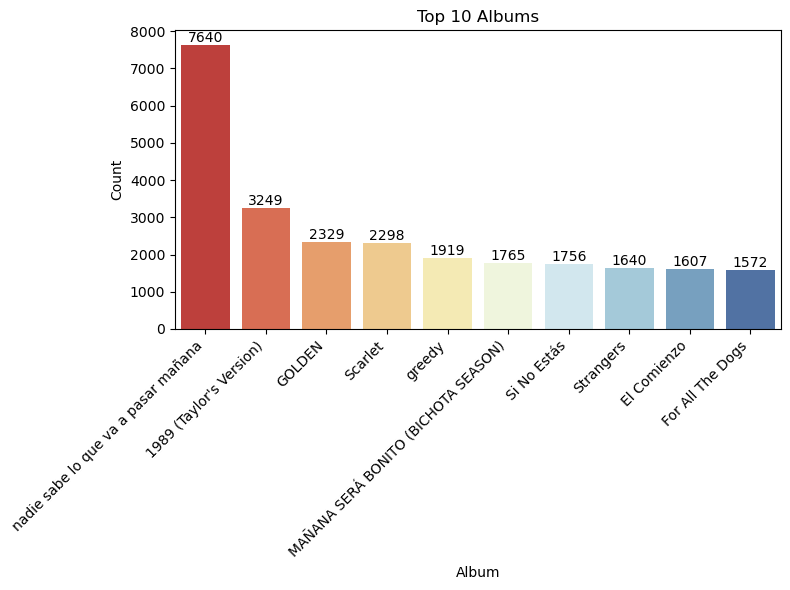

In [23]:
# Get the top 10 albums
top_solo_artists = df['album_name'].value_counts().head(10)

# Create a DataFrame for the top 10 artists
top_solo_artists_df = pd.DataFrame({'Album': top_solo_artists.index, 'Count': top_solo_artists.values})

# Plotting with seaborn
plt.figure(figsize=(8, 6))
plot = sns.barplot(x='Album', y='Count', data=top_solo_artists_df, palette='RdYlBu')

# Display count values on top of the bars
for index, value in enumerate(top_solo_artists_df['Count']):
    plot.text(index, value + 0.1, str(value), ha='center', va='bottom', color='black')

plt.xlabel('Album')
plt.ylabel('Count')
plt.title('Top 10 Albums')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

#plt.savefig('top_solo_artists_collabrations.png', dpi=300)  # Adjust dpi for better resolution

# Show the plot
plt.show()


## 1.5 Represented Countries

In [24]:
import pycountry

# Deep copy
df_country = copy.deepcopy(df)

# Create a mapping between ISO codes and country names
iso_to_country_mapping = {country.alpha_2: country.name for country in pycountry.countries}

# Map ISO codes to country names and remove duplicates
df_country['country'] = df_country['country'].map(iso_to_country_mapping)

# Remove duplicates from the 'country_name' column
countries_list = df_country['country'].drop_duplicates().tolist()

# Displaying the list of unique country names
print(countries_list)
len(countries_list)

[nan, 'South Africa', 'Viet Nam', 'Venezuela, Bolivarian Republic of', 'Uruguay', 'United States', 'Ukraine', 'Taiwan, Province of China', 'Türkiye', 'Thailand', 'El Salvador', 'Slovakia', 'Singapore', 'Sweden', 'Saudi Arabia', 'Romania', 'Paraguay', 'Portugal', 'Poland', 'Pakistan', 'Philippines', 'Peru', 'Panama', 'New Zealand', 'Norway', 'Netherlands', 'Nicaragua', 'Nigeria', 'Malaysia', 'Mexico', 'Morocco', 'Latvia', 'Luxembourg', 'Lithuania', 'Kazakhstan', 'Korea, Republic of', 'Japan', 'Italy', 'Iceland', 'India', 'Israel', 'Ireland', 'Indonesia', 'Hungary', 'Honduras', 'Hong Kong', 'Guatemala', 'Greece', 'United Kingdom', 'France', 'Finland', 'Spain', 'Egypt', 'Estonia', 'Ecuador', 'Dominican Republic', 'Denmark', 'Germany', 'Czechia', 'Costa Rica', 'Colombia', 'Chile', 'Switzerland', 'Canada', 'Belarus', 'Brazil', 'Bolivia, Plurinational State of', 'Bulgaria', 'Belgium', 'Australia', 'Austria', 'Argentina', 'United Arab Emirates']


73

As we see, there are total of 72 countries (excluding Global playlist as 'nan'). Here's a sorted list of the provided countries grouped by continents done by ChatGPT 3.5 (11.12.2023):

Africa:

    Morocco
    Nigeria
    South Africa

Asia:

    Hong Kong
    India
    Indonesia
    Japan
    Kazakhstan
    Korea, Republic of
    Malaysia
    Pakistan
    Philippines
    Saudi Arabia
    Taiwan, Province of China
    Thailand
    Türkiye
    United Arab Emirates
    Viet Nam

Europe:

    Austria
    Belarus
    Belgium
    Bulgaria
    Czechia
    Denmark
    Estonia
    Finland
    France
    Germany
    Greece
    Hungary
    Iceland
    Ireland
    Italy
    Latvia
    Lithuania
    Luxembourg
    Netherlands
    Norway
    Poland
    Portugal
    Romania
    Slovakia
    Spain
    Sweden
    Switzerland
    Ukraine
    United Kingdom

North and Central America:

    Canada
    El Salvador
    Guatemala
    Honduras
    Mexico
    Nicaragua
    Panama
    United States

Oceania:

    Australia
    New Zealand

South America:

    Argentina
    Bolivia, Plurinational State of
    Brazil
    Chile
    Colombia
    Paraguay
    Peru
    Uruguay
    Venezuela, Bolivarian Republic of

## 1.6 Computational Statistics for Numerical Attributes
Here we present the computational statistics for all the numerical attributes for **unique** songs only as we exclude repetitions.

#### 1.6.1 Continuous Attributes

In [25]:
df_unique_songs = df.drop_duplicates(subset='spotify_id')

columns_to_drop = ['spotify_id', 'name', 'artists','daily_rank','daily_movement','weekly_movement', 'country', 'snapshot_date', 'popularity', 'album_name', 'album_release_date']
df_numerical = df_unique_songs.drop(columns_to_drop, axis="columns")
df_numerical.describe()

,is_explicit,duration_s,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000,3882.000000
mean,0.325863,192.735322,0.677470,0.642556,5.444616,-7.065209,0.500000,0.118647,0.284708,0.022599,0.179318,0.525711,121.631789,3.941783
std,0.468757,55.258515,0.140504,0.170649,3.552985,2.797898,0.500064,0.110373,0.254442,0.110940,0.135027,0.221148,28.129576,0.344592
min,0.000000,34.285000,0.159000,0.012400,0.000000,-31.042000,0.000000,0.023000,0.000008,0.000000,0.015400,0.027100,47.914000,1.000000
25%,0.000000,157.490250,0.588000,0.534000,2.000000,-8.392500,0.000000,0.042100,0.072500,0.000000,0.098125,0.360000,98.999250,4.000000
50%,0.000000,184.664000,0.698000,0.659000,6.000000,-6.679500,0.500000,0.069300,0.203000,0.000001,0.124000,0.525500,120.025000,4.000000
75%,1.000000,218.999500,0.779000,0.767000,8.000000,-5.234250,1.000000,0.158000,0.452000,0.000138,0.220000,0.691000,140.023000,4.000000
max,1.000000,641.941000,0.982000,0.997000,11.000000,1.155000,1.000000,0.912000,0.996000,0.970000,0.968000,0.981000,217.969000,5.000000


Finally, let's visualize the output:

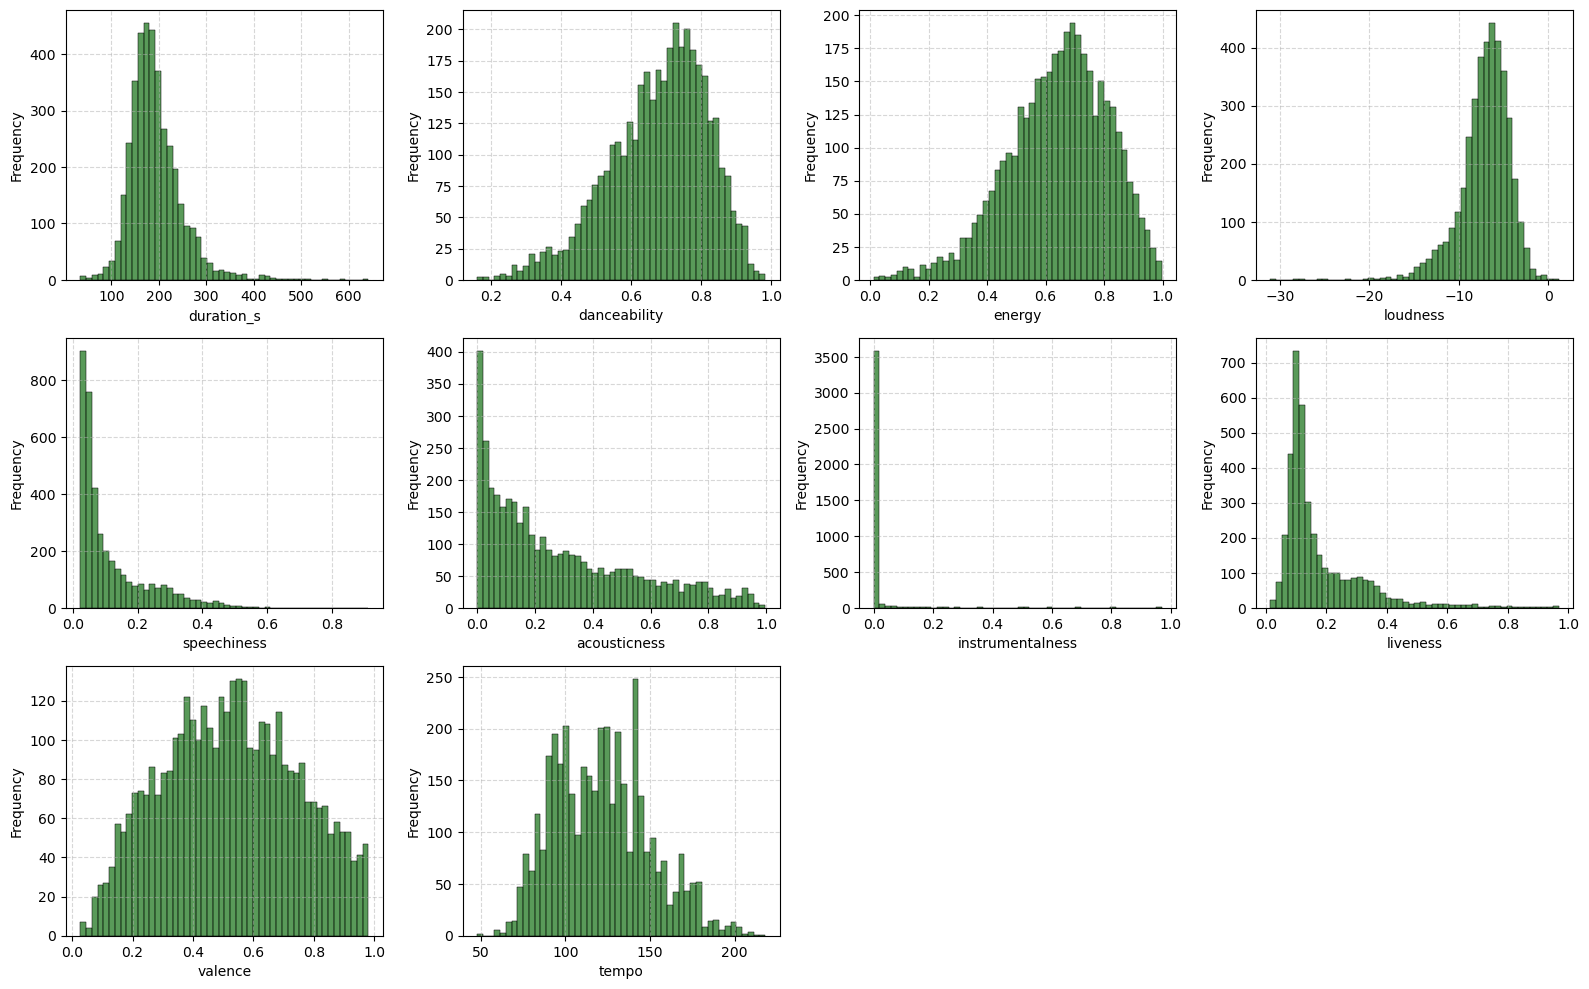

In [26]:
features = ['duration_s', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df_numerical[feature], bins=50, color='darkgreen', alpha=0.65)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5, zorder=0)

plt.tight_layout()

#plt.savefig('histo_features.png', dpi=300)  # Adjust dpi for better resolution

plt.show()


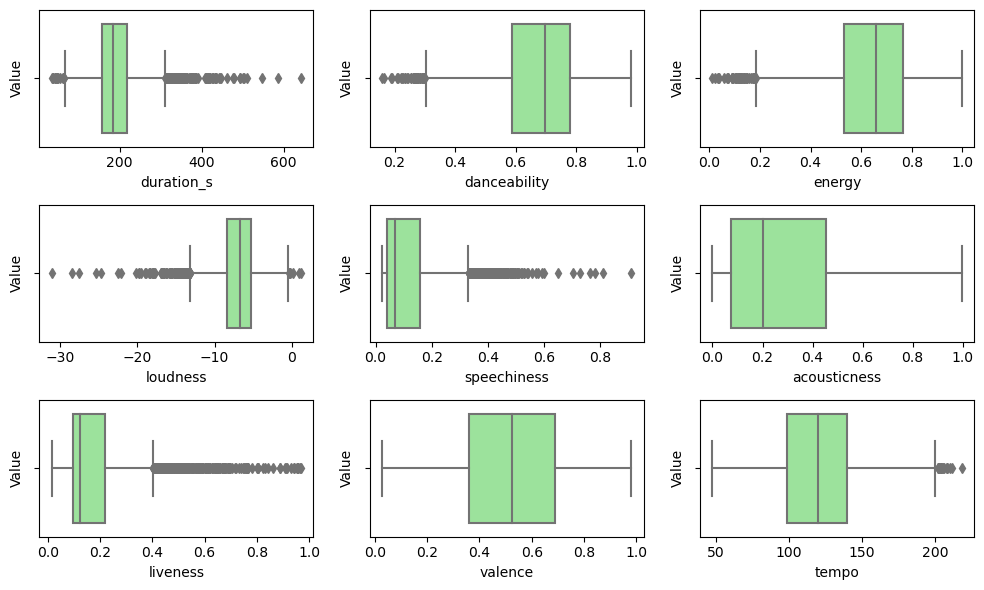

In [27]:
features = ['duration_s', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo']
# instrumentalness is not visualized as it was not visually well presentable.

plt.figure(figsize=(10, 6))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df_numerical[feature], color='lightgreen')
    plt.xlabel(feature)
    plt.ylabel('Value')

plt.tight_layout()

#plt.savefig('boxplot_features.png', dpi=300)  # Adjust dpi for better resolution

plt.show()


### 1.6.2 Discrete Attributes

Here we visualize the discrete attributes: key, time_signature, mode, and is_explicit.

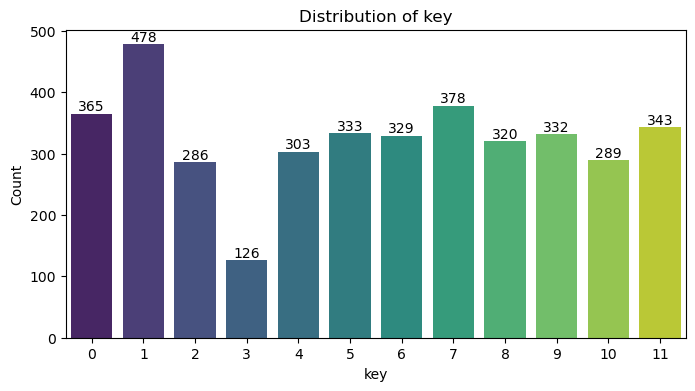

In [28]:
# Set up a bar plot
plt.figure(figsize=(8, 4))
sns.countplot(x='key', data=df_numerical, palette='viridis')

# Display labels floating on the top of each bar without decimal points
for p in plt.gca().patches:
    count = int(p.get_height())  # Convert count to integer
    plt.gca().annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),
                       ha='center', va='bottom', color='black', fontsize=10)

# Set titles and labels
plt.title(f'Distribution of key')
plt.xlabel('key')
plt.ylabel('Count')

#plt.savefig('barplot_key.png', dpi=300)  # Adjust dpi for better resolution

plt.show()

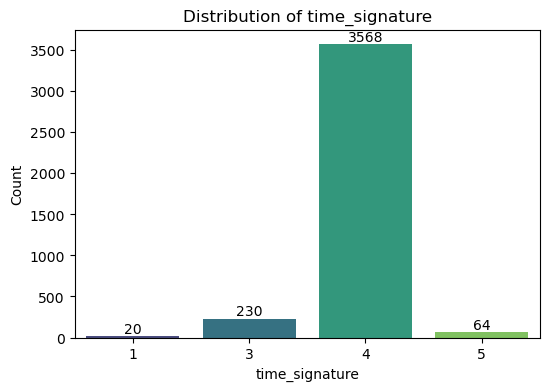

In [29]:
# Set up a bar plot
plt.figure(figsize=(6, 4))
sns.countplot(x='time_signature', data=df_numerical, palette='viridis')

# Display labels directly on top of each bar without decimal points
for p in plt.gca().patches:
    count = int(p.get_height())  # Convert count to integer
    plt.gca().annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', color='black', fontsize=10)

# Set titles and labels
plt.title(f'Distribution of time_signature')
plt.xlabel('time_signature')
plt.ylabel('Count')

#plt.savefig('barplot_time_signature.png', dpi=300)  # Adjust dpi for better resolution

plt.show()

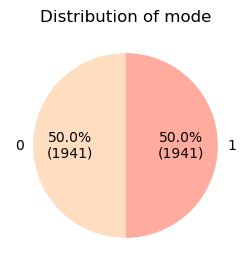

In [30]:
# Custom color palette for better aesthetics
colors = ['#FFDDC1', '#FFAC9E']

# Set up a figure for the pie chart
fig, ax = plt.subplots(figsize=(3, 3))

# Create pie chart for the specified attribute
counts = df_numerical['mode'].value_counts()
wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(counts) / 100), startangle=90, colors=colors)

# Set a title for the pie chart
ax.set_title(f'Distribution of mode')

#plt.savefig('pie_mode.png', dpi=300)  # Adjust dpi for better resolution

plt.show()

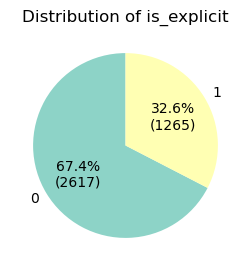

In [31]:
colors = sns.color_palette("Set3", 3)

# Set up a figure for the pie chart
fig, ax = plt.subplots(figsize=(3, 3))

# Create pie chart for the specified attribute
counts = df_numerical['is_explicit'].value_counts()
wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p * sum(counts) / 100), startangle=90, colors=colors)

# Set a title for the pie chart
ax.set_title(f'Distribution of is_explicit')

#plt.savefig('pie_is_explicit.png', dpi=300)  # Adjust dpi for better resolution

plt.show()

# 2. Correlation Matrix

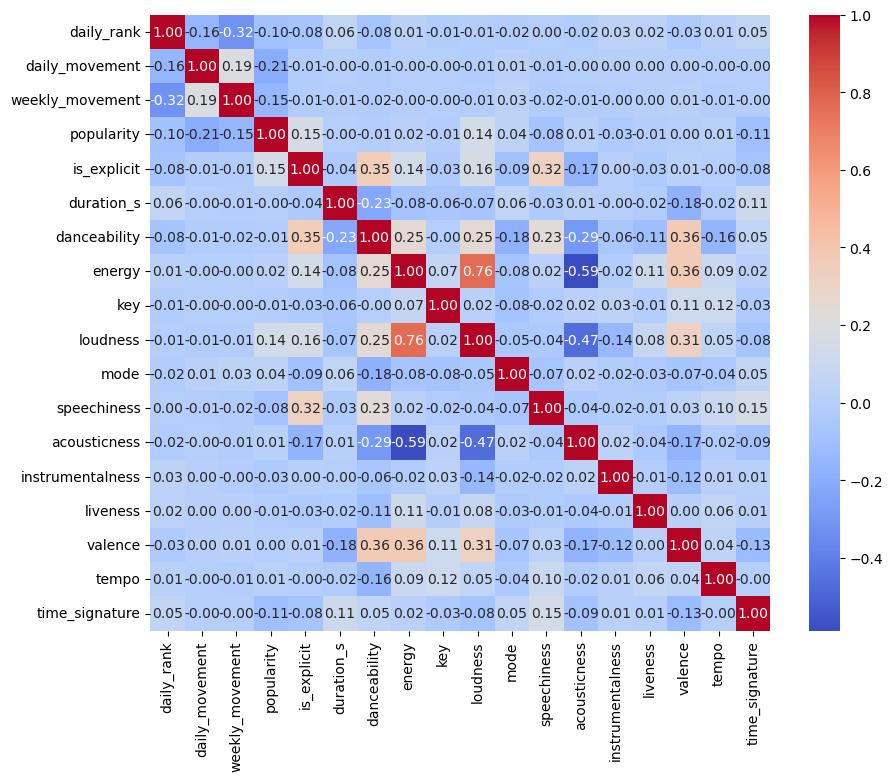

In [32]:
# Exclude non-numeric columns from the DataFrame before calculating the correlation
numeric_df = df.select_dtypes(include=[np.number])

# Now calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Continue with your code to plot the heatmap
# Example:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

#plt.savefig('correlation_matrix.png', dpi=300)  # Adjust dpi for better resolution

plt.show()


As we see attributes loudness and energy are quite strongly correlated (r = 0.76). Acousticness and energy (r = -0.59), and acousticness and loudness (r = -0.47) are moderately correlated.

# 3. Multi-variate Linear Regression Models
In linear regression models we consider only playlists where 'country' == 'Global' as they are already a summary of all the other 72 playlists created on one day.

In [33]:
# Let's filter out Global playlist results
df_global = copy.deepcopy(df)
df_global = df_global[df_global['country'] == "Global"]

# Let's remove some unnessasary and object columns for training
columns_to_drop = ['spotify_id', 'country','name', 'artists', 'daily_movement','weekly_movement', 'snapshot_date', 'popularity', 'album_name', 'album_release_date']
df_global = df_global.drop(columns_to_drop, axis="columns")


Now let's visualize the data points:

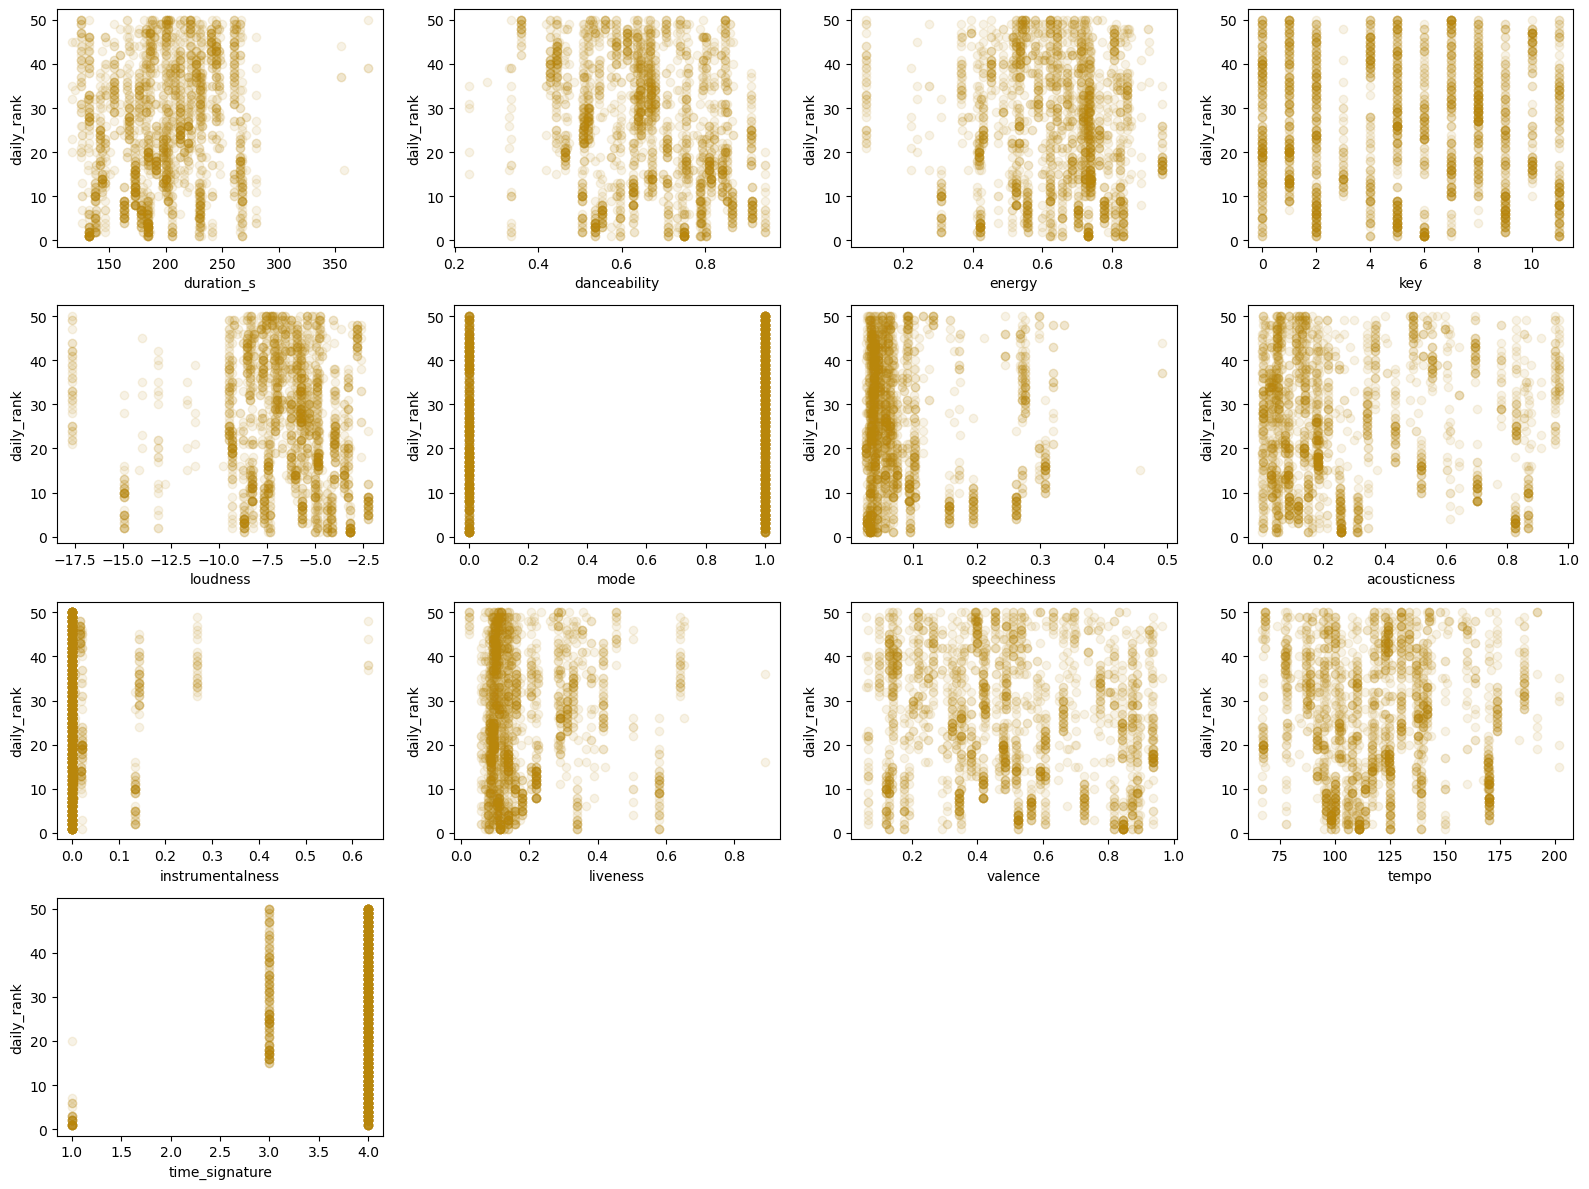

In [34]:
features = ['duration_s', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 4, i)
    plt.scatter(df_global[feature], df_global['daily_rank'], alpha=0.1, c='darkgoldenrod')
    plt.xlabel(feature)
    plt.ylabel('daily_rank')

plt.tight_layout()

#plt.savefig('global_histo_dailyrank_features.png', dpi=300)  # Adjust dpi for better resolution

plt.show()


And now let's start training and figuring out the best linear regression model (Linear, Lasso or Ridge). We can go

1) straight forward with all numerical features or  
2) find out first statistically significant (p = 0.05) features.

## 3.1 Straight Forward With All Numerical Features

In [35]:
# Separate the data into training (80%) and test data (20%)
X_global = df_global.drop("daily_rank", axis="columns")
y_global = df_global["daily_rank"]
X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(X_global, y_global, train_size=0.8, random_state=1)
X_train_global.shape


(1724, 14)

In [36]:
def MSE(y_target, y_pred):
    return np.mean((y_target - y_pred) ** 2)

def RMSE(y_target, y_pred):
    return np.sqrt(MSE(y_target, y_pred))

In [37]:
# Train 3 different linear models and calculate the MSE on test data for each model.

global_ls_model = LinearRegression()
global_ls_model.fit(X_train_global, y_train_global)
global_ls_predictions = global_ls_model.predict(X_test_global)
global_ls_mse = MSE(y_test_global, global_ls_predictions)
global_ls_rmse = RMSE(y_test_global, global_ls_predictions)
global_ls_r2 = r2_score(y_test_global, global_ls_predictions)

global_lasso_model = Lasso()
global_lasso_model.fit(X_train_global, y_train_global)
global_lasso_predictions = global_lasso_model.predict(X_test_global)
global_lasso_mse = MSE(y_test_global, global_lasso_predictions)
global_lasso_r2 = r2_score(y_test_global, global_lasso_predictions)

global_ridge_model = Ridge()
global_ridge_model.fit(X_train_global, y_train_global)
global_ridge_predictions = global_ridge_model.predict(X_test_global)
global_ridge_mse = MSE(y_test_global, global_ridge_predictions)
global_ridge_r2 = r2_score(y_test_global, global_ridge_predictions)


print("MSE for Linear Regression:", global_ls_mse)
print("Rscore for Linear Regression:", global_ls_r2)
print("\nMSE for Lasso Regression:", global_lasso_mse)
print("Rscore for Lasso Regression:", global_lasso_r2)
print("\nMSE for Ridge Regression:", global_ridge_mse)
print("Rscore for Ridge Regression:", global_ridge_r2)

MSE for Linear Regression: 189.80796070330993
Rscore for Linear Regression: 0.11849430936734884

MSE for Lasso Regression: 204.7955177518499
Rscore for Lasso Regression: 0.0488891317024317

MSE for Ridge Regression: 189.60362524883905
Rscore for Ridge Regression: 0.11944328361082457


In [38]:
# Use cross-validation on training dataset to find better regularization parameter alpha for Ridge and Lasso regression models. 
def get_best_alpha(model,X,y,alphas):
    kf = KFold(n_splits=3, random_state = 0, shuffle=True)
    results = []
    for alpha in alphas:
        model.set_params(alpha=alpha)
        for train_indexes, val_indexes in kf.split(X):
            X_train, X_val = X.values[train_indexes], X.values[val_indexes]
            y_train, y_val = y.values[train_indexes], y.values[val_indexes]

            model.fit(X_train, y_train)
            mse = mean_squared_error(y_val,model.predict(X_val))
            results.append((alpha, mse))
   

    best_alpha, mse = sorted(results, key=lambda x: x[1])[0]
    return best_alpha, mse

In [39]:
#  Lasso regularization may set some of the coefficients (weights) to zero

global_lasso_model.fit(X_train_global, y_train_global)
coefficients = global_lasso_model.coef_

global_zero_coefficient_features = X_train_global.columns[coefficients == 0]
print("Features with zero coefficients:", global_zero_coefficient_features)


Features with zero coefficients: Index(['is_explicit', 'danceability', 'energy', 'key', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence',
       'time_signature'],
      dtype='object')


In [40]:
#  Find new alpha values for Ridge and Lasso linear models.

global_ridge_alphas = np.linspace(0.1, 10, 100)
global_lasso_alphas = np.linspace(0.001, 5, 100)

print("Ridge best alpha %.4f - Avg MSE %.4f " % get_best_alpha(Ridge(), X_train_global, y_train_global, global_ridge_alphas))
print("Lasso best alpha %.4f - Avg MSE %.4f " % get_best_alpha(Lasso(), X_train_global, y_train_global, global_lasso_alphas))


Ridge best alpha 0.1000 - Avg MSE 187.8369 
Lasso best alpha 0.0010 - Avg MSE 187.7640 


In [41]:
# Use these alpha parameters to train new Ridge and Lasso models.
# Calculate and report MSE on test data for both of them.

lasso_model = Lasso(alpha=0.0010)
global_lasso_model.fit(X_train_global, y_train_global)
global_lasso_predictions = global_lasso_model.predict(X_test_global)
global_lasso_mse = MSE(y_test_global, global_lasso_predictions)
global_lasso_r2 = r2_score(y_test_global, global_lasso_predictions)

global_ridge_model = Ridge(alpha=0.1000)
global_ridge_model.fit(X_train_global, y_train_global)
global_ridge_predictions = global_ridge_model.predict(X_test_global)
global_ridge_mse = MSE(y_test_global, global_ridge_predictions)
global_ridge_r2 = r2_score(y_test_global, global_ridge_predictions)

print("MSE for Lasso Regression:", global_lasso_mse)
print("Rscore for Lasso Regression:", global_lasso_r2)
print("\nMSE for Ridge Regression:", global_ridge_mse)
print("Rscore for Ridge Regression:", global_ridge_r2)

MSE for Lasso Regression: 204.7955177518499
Rscore for Lasso Regression: 0.0488891317024317

MSE for Ridge Regression: 189.77693731429332
Rscore for Ridge Regression: 0.11863838811862737


**The best model seems to be Ridge Regression (MSE = 189.778 and R\*\*2 =0.119)**

In [42]:
global_ridge_model.fit(X_train_global, y_train_global)
global_coefficients_ridge = global_ridge_model.coef_
display(global_coefficients_ridge)

# Evaluation
global_ridge_mse = mean_squared_error(y_test_global, global_ridge_predictions)
global_ridge_r2 = r2_score(y_test_global, global_ridge_predictions)

print("MSE for Ridge Regression:", global_ridge_mse)
print("R2_score for Ridge Regression:", global_ridge_r2)

# coefficients
# array([ 1.04739293,  0.0324319364, -29.7635255, -0.0708081198,
       # -0.0162002989,  0.356200321,  0.375681479,  1.68765823,
       # -1.88571744,  17.6280805, -0.101662686, -0.487983872,
       # -0.0162768145,  1.98058430])
# features
# (   'is_explicit', 'duration_s', 'danceability', 'energy',
    # 'key', 'loudness', 'mode', 'speechiness',
    # 'acousticness','instrumentalness', 'liveness', 'valence',
    # 'tempo', 'time_signature'
        
# IMPACTS
    # mida suurem, seda kõrgem edetabelikoht:
    # negative impact - the higher the value, the higher the ranking (as the ranking "rises")
        # 1. 'danceability' -29.764
        # 2. 'acousticness' -1.886
        # 3. 'valence' -0.488
        # 4. 'liveness' -0.102
        # 5. 'energy' -0.071
        # 6. 'tempo' -0.016
        # 7. 'key' -0.016
    # mida suurem, seda kehvem edetabelikoht:
    # positive impact - the higher the value, the lower the ranking (as the ranking "drops")
        # 1. 'instrumentalness' 17.628
        # 2. 'speechiness' 1.688
        # 3. 'time_signature' 1.981
        # 4. 'is_explicit' 1.047
        # 5. 'mode' 0.376
        # 6. 'loudness' 0.356
        # 7. 'duration_s' 0.0324

array([ 1.04739293e+00,  3.24319364e-02, -2.97635255e+01, -7.08081198e-02,
       -1.62002989e-02,  3.56200321e-01,  3.75681479e-01,  1.68765823e+00,
       -1.88571744e+00,  1.76280805e+01, -1.01662686e-01, -4.87983872e-01,
       -1.62768145e-02,  1.98058430e+00])

MSE for Ridge Regression: 189.77693731429332
R2_score for Ridge Regression: 0.11863838811862737


## 3.2 Finding Statistically Significant (p = 0.05) Features

After some time only the statistically significant features remained. Order of removing features: "mode", "energy", "key", "speechiness", "tempo", "valence", "liveness", "loudness".

In [43]:
columns_to_drop = ["mode", "energy", "key", "speechiness", "tempo", "valence", "liveness", "loudness"]
X_global_sign = df_global[['duration_s', 'danceability', 'acousticness', 'instrumentalness', 'time_signature']]  # Select your features
y_global_sign = df_global['daily_rank']

X_global_sign = sm.add_constant(X_global_sign)  # Add a constant term to the features

model = sm.OLS(y_global_sign, X_global_sign).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             daily_rank   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     49.18
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           2.44e-48
Time:                        11:23:40   Log-Likelihood:                -8699.7
No. Observations:                2156   AIC:                         1.741e+04
Df Residuals:                    2150   BIC:                         1.745e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               27.8898      3.546  

In [44]:
# Separate the data into training (80%) and test data (20%)
X_global_sign = df_global[['duration_s', 'danceability', 'acousticness', 'instrumentalness', 'time_signature']]
y_global_sign = df_global['daily_rank']
X_train_global_sign, X_test_global_sign, y_train_global_sign, y_test_global_sign = train_test_split(X_global_sign, y_global_sign, train_size=0.8, random_state=1)


In [45]:
global_ls_model_sign = LinearRegression()
global_ls_model_sign.fit(X_train_global_sign, y_train_global_sign)
global_ls_predictions_sign = global_ls_model_sign.predict(X_test_global_sign)
global_ls_mse_sign = MSE(y_test_global_sign, global_ls_predictions_sign)
global_ls_rmse_sign = RMSE(y_test_global_sign, global_ls_predictions_sign)
global_ls_r2_sign = r2_score(y_test_global_sign, global_ls_predictions_sign)

global_lasso_model_sign = Lasso()
global_lasso_model_sign.fit(X_train_global_sign, y_train_global_sign)
global_lasso_predictions_sign = global_lasso_model_sign.predict(X_test_global_sign)
global_lasso_mse_sign = MSE(y_test_global_sign, global_lasso_predictions_sign)
global_lasso_r2_sign = r2_score(y_test_global_sign, global_lasso_predictions_sign)

global_ridge_model_sign = Ridge()
global_ridge_model_sign.fit(X_train_global_sign, y_train_global_sign)
global_ridge_predictions_sign = global_ridge_model_sign.predict(X_test_global_sign)
global_ridge_mse_sign = MSE(y_test_global_sign, global_ridge_predictions_sign)
global_ridge_r2_sign = r2_score(y_test_global_sign, global_ridge_predictions_sign)


print("MSE for Linear Regression:", global_ls_mse_sign)
print("Rscore for Linear Regression:", global_ls_r2_sign)
print("\nMSE for Lasso Regression:", global_lasso_mse_sign)
print("Rscore for Lasso Regression:", global_lasso_r2_sign)
print("\nMSE for Ridge Regression:", global_ridge_mse_sign)
print("Rscore for Ridge Regression:", global_ridge_r2_sign)

MSE for Linear Regression: 188.35712523445162
Rscore for Linear Regression: 0.1252322760850324

MSE for Lasso Regression: 205.22903593008
Rscore for Lasso Regression: 0.04687578758511168

MSE for Ridge Regression: 188.31536047384313
Rscore for Ridge Regression: 0.12542623988933155


In [46]:
#  Lasso regularization may set some of the coefficients (weights) to zero

global_lasso_model_sign.fit(X_train_global_sign, y_train_global_sign)
coefficients_sign = global_lasso_model_sign.coef_

global_zero_coefficient_features_sign = X_train_global_sign.columns[coefficients_sign == 0]
print("Features with zero coefficients:", global_zero_coefficient_features_sign)

Features with zero coefficients: Index(['danceability', 'acousticness', 'instrumentalness', 'time_signature'], dtype='object')


In [47]:
#  Find new alpha values for Ridge and Lasso linear models.

global_ridge_alphas_sign = np.linspace(0.1, 10, 100)
global_lasso_alphas_sign = np.linspace(0.001, 5, 100)

print("Ridge best alpha %.4f - Avg MSE %.4f " % get_best_alpha(Ridge(), X_train_global_sign, y_train_global_sign, global_ridge_alphas_sign))
print("Lasso best alpha %.4f - Avg MSE %.4f " % get_best_alpha(Lasso(), X_train_global_sign, y_train_global_sign, global_lasso_alphas_sign))


Ridge best alpha 0.4000 - Avg MSE 187.3898 
Lasso best alpha 0.0010 - Avg MSE 187.4260 


In [48]:
# Use these alpha parameters to train new Ridge and Lasso models.
# Calculate and report MSE on test data for both of them.

lasso_model_sign = Lasso(alpha=0.0010)
global_lasso_model_sign.fit(X_train_global_sign, y_train_global_sign)
global_lasso_predictions_sign = global_lasso_model_sign.predict(X_test_global_sign)
global_lasso_mse_sign = MSE(y_test_global_sign, global_lasso_predictions_sign)
global_lasso_r2_sign = r2_score(y_test_global_sign, global_lasso_predictions_sign)

global_ridge_model_sign = Ridge(alpha=0.4000)
global_ridge_model_sign.fit(X_train_global_sign, y_train_global_sign)
global_ridge_predictions_sign = global_ridge_model_sign.predict(X_test_global_sign)
global_ridge_mse_sign = MSE(y_test_global_sign, global_ridge_predictions_sign)
global_ridge_r2_sign = r2_score(y_test_global_sign, global_ridge_predictions_sign)

print("MSE for Lasso Regression:", global_lasso_mse_sign)
print("Rscore for Lasso Regression:", global_lasso_r2_sign)
print("\nMSE for Ridge Regression:", global_ridge_mse_sign)
print("Rscore for Ridge Regression:", global_ridge_r2_sign)

MSE for Lasso Regression: 205.22903593008
Rscore for Lasso Regression: 0.04687578758511168

MSE for Ridge Regression: 188.3294269709754
Rscore for Ridge Regression: 0.12536091229599244


**The best model still seems to be Ridge Regression (MSE = 188.329 and R\*\*2 = 0.125)**

In [49]:
global_ridge_model_sign.fit(X_train_global_sign, y_train_global_sign)
global_coefficients_ridge_sign = global_ridge_model_sign.coef_
display(global_coefficients_ridge_sign)

# Evaluation
global_ridge_mse_sign = mean_squared_error(y_test_global_sign, global_ridge_predictions_sign)
global_ridge_r2_sign = r2_score(y_test_global_sign, global_ridge_predictions_sign)

print("MSE for Ridge Regression:", global_ridge_mse_sign)
print("R2_score for Ridge Regression:", global_ridge_r2_sign)

array([  0.03560148, -25.58112563,  -3.63418716,  17.00453461,
         1.63229805])

MSE for Ridge Regression: 188.3294269709754
R2_score for Ridge Regression: 0.12536091229599244


In [50]:
# coefficients
# array([  0.03560148, -25.58112563,  -3.63418716,  17.00453461,
         # 1.63229805])
# features
# (       'duration_s', 'danceability', 'acousticness',
        # 'instrumentalness', 'time_signature'
        
# IMPACTS
    # mida suurem, seda kõrgem edetabelikoht:
    # negative impact - the higher the value, the higher the ranking (as the ranking "rises")
        # 1. 'danceability' -25.581
        # 2. 'acousticness' -3.634
    # mida suurem, seda kehvem edetabelikoht:
    # positive impact - the higher the value, the lower the ranking (as the ranking "drops")
        # 1. 'instrumentalness' 17.005
        # 2. 'time_signature' 1.632
        # 3. 'duration_s' 0.036
        

# 4. Random Forest

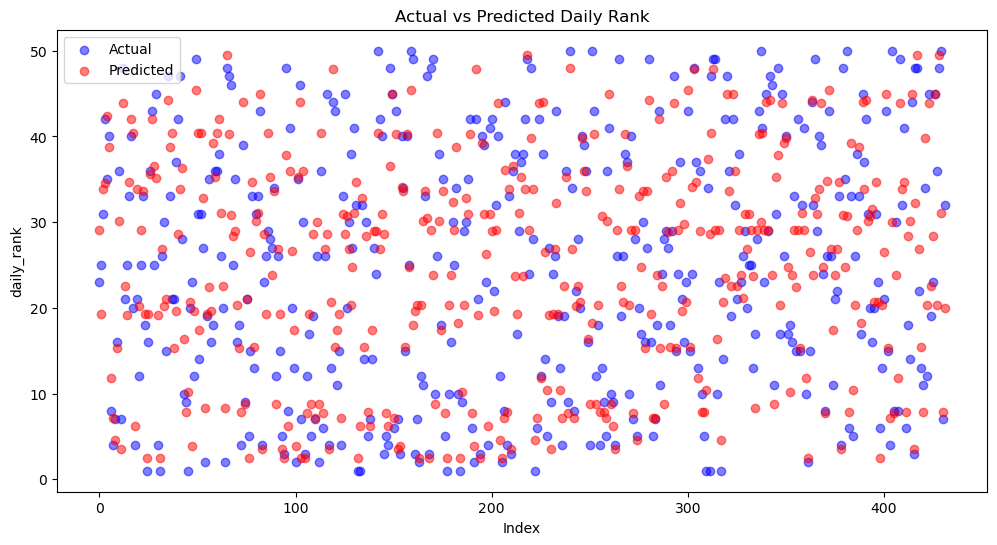

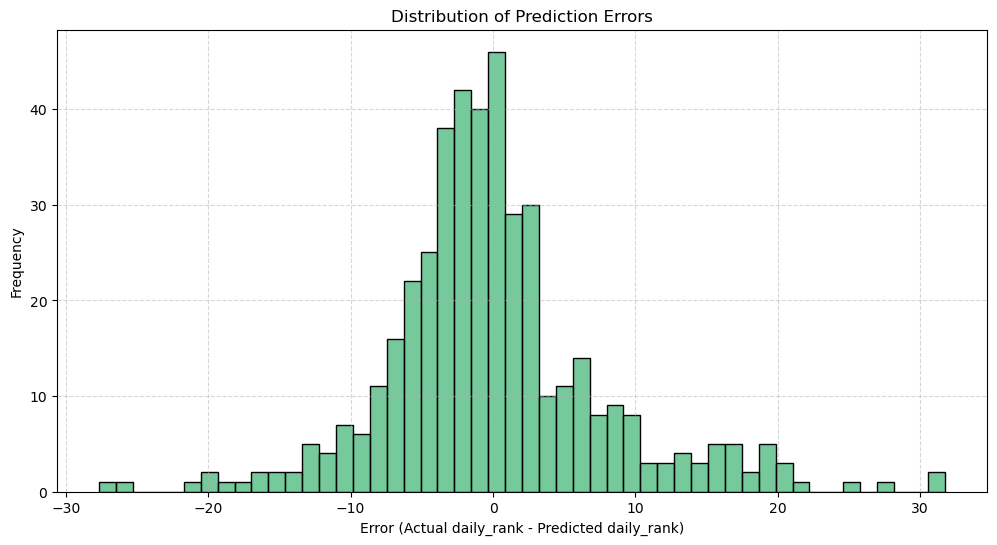

MSE for Random forest: 60.49395217109671
R2_score for Random forest: 0.7190541277083998


In [51]:
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_global)
X_test_scaled = scaler.transform(X_test_global)

# Note: You generally don't scale the target variable for regression tasks.
# y_train_scaled = scaler.fit_transform(y_train_global)
# y_test_scaled = scaler.transform(y_test_global)

# Building and training the Random Forest model
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X_train_scaled, y_train_global)

# Predictions
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluation
rf_mse = mean_squared_error(y_test_global, rf_predictions)
rf_r2 = r2_score(y_test_global, rf_predictions)



# Actual vs Predicted Daily Rank Visualization
comparison_df = pd.DataFrame({'Actual daily_rank': y_test_global, 'Predicted daily_rank': rf_predictions})
comparison_df = comparison_df.reset_index(drop=True)
plt.figure(figsize=(12, 6))
plt.scatter(comparison_df.index, comparison_df['Actual daily_rank'], color='blue', alpha=0.5, label='Actual')
plt.scatter(comparison_df.index, comparison_df['Predicted daily_rank'], color='red', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Daily Rank')
plt.xlabel('Index')
plt.ylabel('daily_rank')
plt.legend()

#plt.savefig('rf_actual_vs_predicted.png', dpi=300)  # Adjust dpi for better resolution

plt.show()

# Error Distribution Visualization
errors = comparison_df['Actual daily_rank'] - comparison_df['Predicted daily_rank']
plt.figure(figsize=(12, 6))
sns.histplot(errors, bins=50, color='mediumseagreen', alpha=0.7)
#plt.hist(errors, bins=50, color='mediumseagreen', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Actual daily_rank - Predicted daily_rank)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5, zorder=0)

#plt.savefig('rf_error_distribution.png', dpi=300)  # Adjust dpi for better resolution

plt.show()

print("MSE for Random forest:", rf_mse)
print("R2_score for Random forest:", rf_r2)

# 5. Conclusions

Finally, we would say that the best model to predict the popularity of the song is **Random Forest**, not a Ridge Regression Model, as the MSE is smaller (60.494 < 188.329) and R\**2 is bigger (0.719 > 0.125):
* Random Forest, MSE = 60.494 and R\**2 = 0.719
* Ridge Regression Model, MSE = 188.329 and R\*\*2 = 0.125

In Random Forest the R\**2 says that 71.9% of the variability in the daily ranks is caused by the features